In [17]:
# %%
# --- セル 1: 必要なライブラリのインポート ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib  # 日本語表示
from pathlib import Path
from tqdm import tqdm
from typing import List, Dict, Iterable, Tuple, Optional
import mne  # MNE-Python

# %%
# --- セル 2: config 変数の定義 ---
# (src.config からのインポートが機能しない場合、ここで直接定義する)
try:
    import _init_notebook
    from src.config import (
        PROCESSED_DIR, TMIN, TMAX, BASELINE, SAMPLING_RATE,
        EEG_CHANNELS_TO_FILTER, EVENT_RANGES, N_JOBS, FREQS
    )
except ImportError:
    print("src.config を読み込めないため、変数を仮設定します。")


# %%
# --- セル 3: ITPC集計関数の定義 ---
def aggregate_itpc_data(
    processed_dir: Path,
    event_ranges: Dict[str, Tuple[int, int]],
    channels: List[str],
    tmin: float,
    tmax: float,
    baseline_sec: Tuple[float, float], # Zスコア化に使用
    sfreq: int,
    freqs: np.ndarray,
    n_jobs: int
) -> Optional[pd.DataFrame]:
    """
    個体ごとのファイルから試行平均ITPCを計算し、Zスコア化して全個体分を集計する。
    参照コードに基づき、mne.time_frequency.tfr_morlet を使用する。
    """
    
    if not isinstance(freqs, np.ndarray):
        freqs = np.array(freqs, dtype=float)
    
    n_cycles = freqs / 2.0

    processed_path = Path(processed_dir)
    files = list(processed_path.glob('*.parquet'))
    read_func_name = 'read_parquet'
    
    if not files:
        files = list(processed_path.glob('*.csv'))
        read_func_name = 'read_csv'
        
    if not files:
        print(f"エラー: {processed_dir} にファイルが見つかりません。")
        return None

    print(f"{len(files)} 個のファイルからITPCを集計します...")
    
    all_itpc_data = []
    required_cols = channels + ['Event_ID', 'Stimulus_Type', 'Subject_ID', 'Genotype']

    for file_path in tqdm(files, desc="Processing files"):
        # ERSPやSTPの集計結果ファイルをスキップ
        if file_path.name.startswith('summary_'):
            print(f"スキップ: {file_path.name}")
            continue
            
        try:
            # --- 1. データ読み込み ---
            if read_func_name == 'read_parquet':
                df = pd.read_parquet(file_path, columns=required_cols)
            else:
                df = pd.read_csv(file_path, usecols=required_cols)

            if df.empty:
                continue

            subject_id = df['Subject_ID'].iloc[0]
            genotype = df['Genotype'].iloc[0]

            # --- 2. MNE RawArray オブジェクトの作成 ---
            data = df[channels].values.T
            info = mne.create_info(ch_names=channels, sfreq=sfreq, ch_types=['eeg'] * len(channels))
            raw = mne.io.RawArray(data, info, verbose=False)

            # --- 3. MNE Events の作成 (Stimulus_Type を int ID にマッピング) ---
            event_starts = df['Event_ID'].diff().fillna(0)
            event_indices = event_starts[event_starts > 0].index
            
            stim_types_at_events = df.loc[event_indices, 'Stimulus_Type']
            
            mne_event_id_dict = {}
            current_id = 1
            if 'No_Stimulus' in event_ranges:
                mne_event_id_dict['No_Stimulus'] = 0
            for stim_name in event_ranges.keys():
                if stim_name not in mne_event_id_dict:
                    mne_event_id_dict[stim_name] = current_id
                    current_id += 1
            
            event_ids = [mne_event_id_dict.get(stim, -1) for stim in stim_types_at_events]
            events = np.array([event_indices, np.zeros_like(event_indices), event_ids]).T.astype(int)
            events = events[events[:, 2] != -1]

            # --- 4. MNE Epochs の作成 ---
            epochs = mne.Epochs(
                raw,
                events=events,
                event_id=mne_event_id_dict,
                tmin=tmin,
                tmax=tmax,
                preload=True,
                baseline=None, # ITPC計算後にベースライン補正
                reject=None,
                verbose=False
            )
            
            del df, raw 

            # --- 5. 刺激ごとのITPC計算 (試行平均) ---
            for stim_name in event_ranges.keys():
                try:
                    stim_epochs = epochs[stim_name]
                    if len(stim_epochs) == 0:
                        continue
                        
                    # 参照コードに基づき tfr_morlet を使用
                    # return_itc=True で ITPC を計算
                    tfr, itpc = mne.time_frequency.tfr_morlet(
                        stim_epochs,
                        freqs=freqs,
                        n_cycles=n_cycles,
                        use_fft=True,
                        return_itc=True,
                        average=True, # メモリ対策: 試行平均
                        n_jobs=n_jobs,
                        verbose=False
                    )
                    
                    # 参照コードに基づき Zスコア化
                    #itpc.apply_baseline(baseline=baseline_sec, mode='zscore', verbose=False)
                    
                    times = itpc.times
                    ch_names_clean = [ch.replace('_filtered', '') for ch in itpc.ch_names]
                    
                    # itpc.data は (n_channels, n_freqs, n_times)
                    for i_ch, ch_name in enumerate(ch_names_clean):
                        for i_freq, freq in enumerate(freqs):
                            for i_time, time in enumerate(times):
                                all_itpc_data.append({
                                    'Subject_ID': subject_id,
                                    'Genotype': genotype,
                                    'Stimulus': stim_name,
                                    'Channel': ch_name,
                                    'Frequency': freq,
                                    'Time': time,
                                    'ITPC_Zscore': itpc.data[i_ch, i_freq, i_time]
                                })
                                
                except KeyError:
                    continue
            
            del epochs 
        except Exception as e:
            print(f"エラー処理中 {file_path.name}: {e}")

    if not all_itpc_data:
        print("集計データがありません。")
        return None
        
    print("DataFrameに変換中...")
    return pd.DataFrame(all_itpc_data)

# %%
# --- セル 4: ITPC可視化関数の定義 (スケール統一・RdBu・フォント拡大版) ---
def plot_grouped_itpc_raw(
    itpc_df: pd.DataFrame,
    clim: Optional[Tuple[float, float]] = None 
):
    """
    集計されたITPC (Z-score) データを使い、TFRヒートマップと差分をプロットする。
    cmap='RdBu_r' (赤-白-青) と単一のclimで統一する。
    フォントサイズを調整。
    """
    if itpc_df is None or itpc_df.empty:
        print("プロットするデータがありません。")
        return

# ★ 修正点: 列名を変更
    if 'ITPC_Raw' not in itpc_df.columns:
        print("エラー: 'ITPC_Raw' 列が見つかりません。セル3で生のITPC値を保存してください。")
        return
    print("プロットを生成中 (スケール統一 RdBuモード)...")
    
    channels_order = [ch.replace('_filtered', '') for ch in EEG_CHANNELS_TO_FILTER]
    stimuli_order = list(EVENT_RANGES.keys())

    # グループ平均を計算
    df_mean_subject = itpc_df.groupby(
        ['Subject_ID', 'Genotype', 'Stimulus', 'Channel', 'Frequency', 'Time']
    )[['ITPC_Zscore']].mean().reset_index()
    
    df_mean_group = df_mean_subject.groupby(
        ['Genotype', 'Stimulus', 'Channel', 'Frequency', 'Time']
    )[['ITPC_Zscore']].mean().reset_index()

    # clim の自動調整 (Zスコアの98%点で対称)
    if clim is None:
        valid_data = df_mean_group['ITPC_Zscore'].dropna()
        if not valid_data.empty:
            abs_max = np.percentile(np.abs(valid_data), 98)
            abs_max = max(abs_max, 1.0) 
            clim = (-abs_max, abs_max)
        else:
            clim = (-1, 1)
        print(f"カラースケールを自動調整 (98%点): {clim}")
    
    n_counts = itpc_df.groupby(['Genotype', 'Stimulus'])['Subject_ID'].nunique()
    
    for stim_name in stimuli_order:
        fig, axes = plt.subplots(
            nrows=len(channels_order),
            ncols=3, 
            figsize=(20, 4 * len(channels_order)),
            sharex=True,
            sharey=True
        )
        if len(channels_order) == 1: axes = np.array([axes])
        if axes.ndim == 1: axes = axes.reshape(1, -1)
        
        # ★ 変更点: フォントサイズ指定
        fig.suptitle(f'ITPC (Z-scored): {stim_name} [スケール: {clim}]', fontsize=18, y=1.03)

        stim_df = df_mean_group[df_mean_group['Stimulus'] == stim_name]
        if stim_df.empty: 
            print(f"Warning: 刺激 '{stim_name}' のデータが見つかりません。")
            plt.close(fig) # 空の図を閉じる
            continue
            
        data_wt = stim_df[stim_df['Genotype'] == 'WT']
        data_het = stim_df[stim_df['Genotype'] == 'Het']
        n_wt = n_counts.get(('WT', stim_name), 0)
        n_het = n_counts.get(('Het', stim_name), 0)
        times_idx = stim_df['Time'].unique(); times_idx.sort()
        freqs_idx = stim_df['Frequency'].unique(); freqs_idx.sort()
        
        c_main = None

        for i, channel in enumerate(channels_order):
            wt_plot_data = data_wt[data_wt['Channel'] == channel]
            wt_pivot = wt_plot_data.pivot_table(index='Frequency', columns='Time', values='ITPC_Zscore').reindex(index=freqs_idx, columns=times_idx) if not wt_plot_data.empty else pd.DataFrame(np.nan, index=freqs_idx, columns=times_idx)
            het_plot_data = data_het[data_het['Channel'] == channel]
            het_pivot = het_plot_data.pivot_table(index='Frequency', columns='Time', values='ITPC_Zscore').reindex(index=freqs_idx, columns=times_idx) if not het_plot_data.empty else pd.DataFrame(np.nan, index=freqs_idx, columns=times_idx)
            diff_pivot = wt_pivot.subtract(het_pivot)

            ax_wt = axes[i, 0]; ax_het = axes[i, 1]; ax_diff = axes[i, 2]

            # --- ★ 変更点: cmap='RdBu_r' に変更 ---
            # WT (左)
            c_main = ax_wt.pcolormesh(
                wt_pivot.columns, wt_pivot.index, wt_pivot.values,
                cmap='bwr', 
                vmin=clim[0], vmax=clim[1], 
                shading='gouraud'
            )
            ax_wt.axvline(x=0, color='black', linestyle='--', linewidth=1)
            ax_wt.set_title(f'WT (n={n_wt})', fontsize=14) # ★ フォントサイズ
            ax_wt.set_ylabel(f'{channel}\n周波数 (Hz)', fontsize=12) # ★ フォントサイズ

            # Het (中)
            ax_het.pcolormesh(
                het_pivot.columns, het_pivot.index, het_pivot.values,
                cmap='bwr',
                vmin=clim[0], vmax=clim[1], 
                shading='gouraud'
            )
            ax_het.axvline(x=0, color='black', linestyle='--', linewidth=1)
            ax_het.set_title(f'Het (n={n_het})', fontsize=14) # ★ フォントサイズ
            
            # Diff (右)
            if not diff_pivot.empty:
                ax_diff.pcolormesh(
                    diff_pivot.columns, diff_pivot.index, diff_pivot.values,
                    cmap='bwr', 
                    vmin=clim[0], vmax=clim[1], 
                    shading='gouraud'
                )
            ax_diff.axvline(x=0, color='black', linestyle='--', linewidth=1)
            ax_diff.set_title(f'Difference (WT - Het)', fontsize=14) # ★ フォントサイズ
            
            if i == len(channels_order) - 1:
                ax_wt.set_xlabel('時間 (秒)', fontsize=12) # ★ フォントサイズ
                ax_het.set_xlabel('時間 (秒)', fontsize=12) # ★ フォントサイズ
                ax_diff.set_xlabel('時間 (秒)', fontsize=12) # ★ フォントサイズ
            
            # ★ 変更点: 軸の目盛りフォントサイズ
            ax_wt.tick_params(axis='both', labelsize=11)
            ax_het.tick_params(axis='both', labelsize=11)
            ax_diff.tick_params(axis='both', labelsize=11)


        # カラーバー (1本に統一)
        if c_main:
             # ★ 変更点: ラベルのフォントサイズ
             cbar = fig.colorbar(c_main, ax=axes.ravel().tolist(), label='ITPC (Z-score)', 
                                 shrink=0.8, pad=0.015, aspect=30)
             cbar.set_label('ITPC (Z-score)', size=12)
             cbar.ax.tick_params(labelsize=11)
        
        fig.tight_layout(rect=[0, 0, 0.94, 0.97]) # topを調整
        plt.show()

In [ ]:

# %%
# --- セル 5: メイン実行部分 ---
if __name__ == "__main__":
    
    # データ集計の実行
    print("ITPCデータの集計を開始します...")
    itpc_dataframe = aggregate_itpc_data(
        processed_dir=PROCESSED_DIR,
        event_ranges=EVENT_RANGES,
        channels=EEG_CHANNELS_TO_FILTER,
        tmin=TMIN,
        tmax=TMAX,
        baseline_sec=BASELINE, # Zスコア化に使用
        sfreq=SAMPLING_RATE,
        freqs=FREQS,
        n_jobs=N_JOBS
    )
    
    if itpc_dataframe is not None:
        print("\nITPCデータ集計が完了しました。")
        
        # 集計結果を保存 (強く推奨)
        output_path = PROCESSED_DIR / "summary_itpc_all_subjects.parquet"
        print(f"集計結果を {output_path} に保存します...")
        itpc_dataframe.to_parquet(output_path, index=False)
        print("保存が完了しました。")

        # 可視化の実行
        # スケールは自動調整 (None)
        plot_grouped_itpc(itpc_dataframe, clim_main=None, clim_diff=None) 
        
    else:
        print("エラー: 集計データが空です。")

プロットを生成中 (スケール統一 RdBuモード)...
カラースケールを自動調整 (98%点): (np.float64(-18.51388580027429), np.float64(18.51388580027429))


C:\Users\dmasu\AppData\Local\Temp\ipykernel_16148\2980590038.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.94, 0.97]) # topを調整


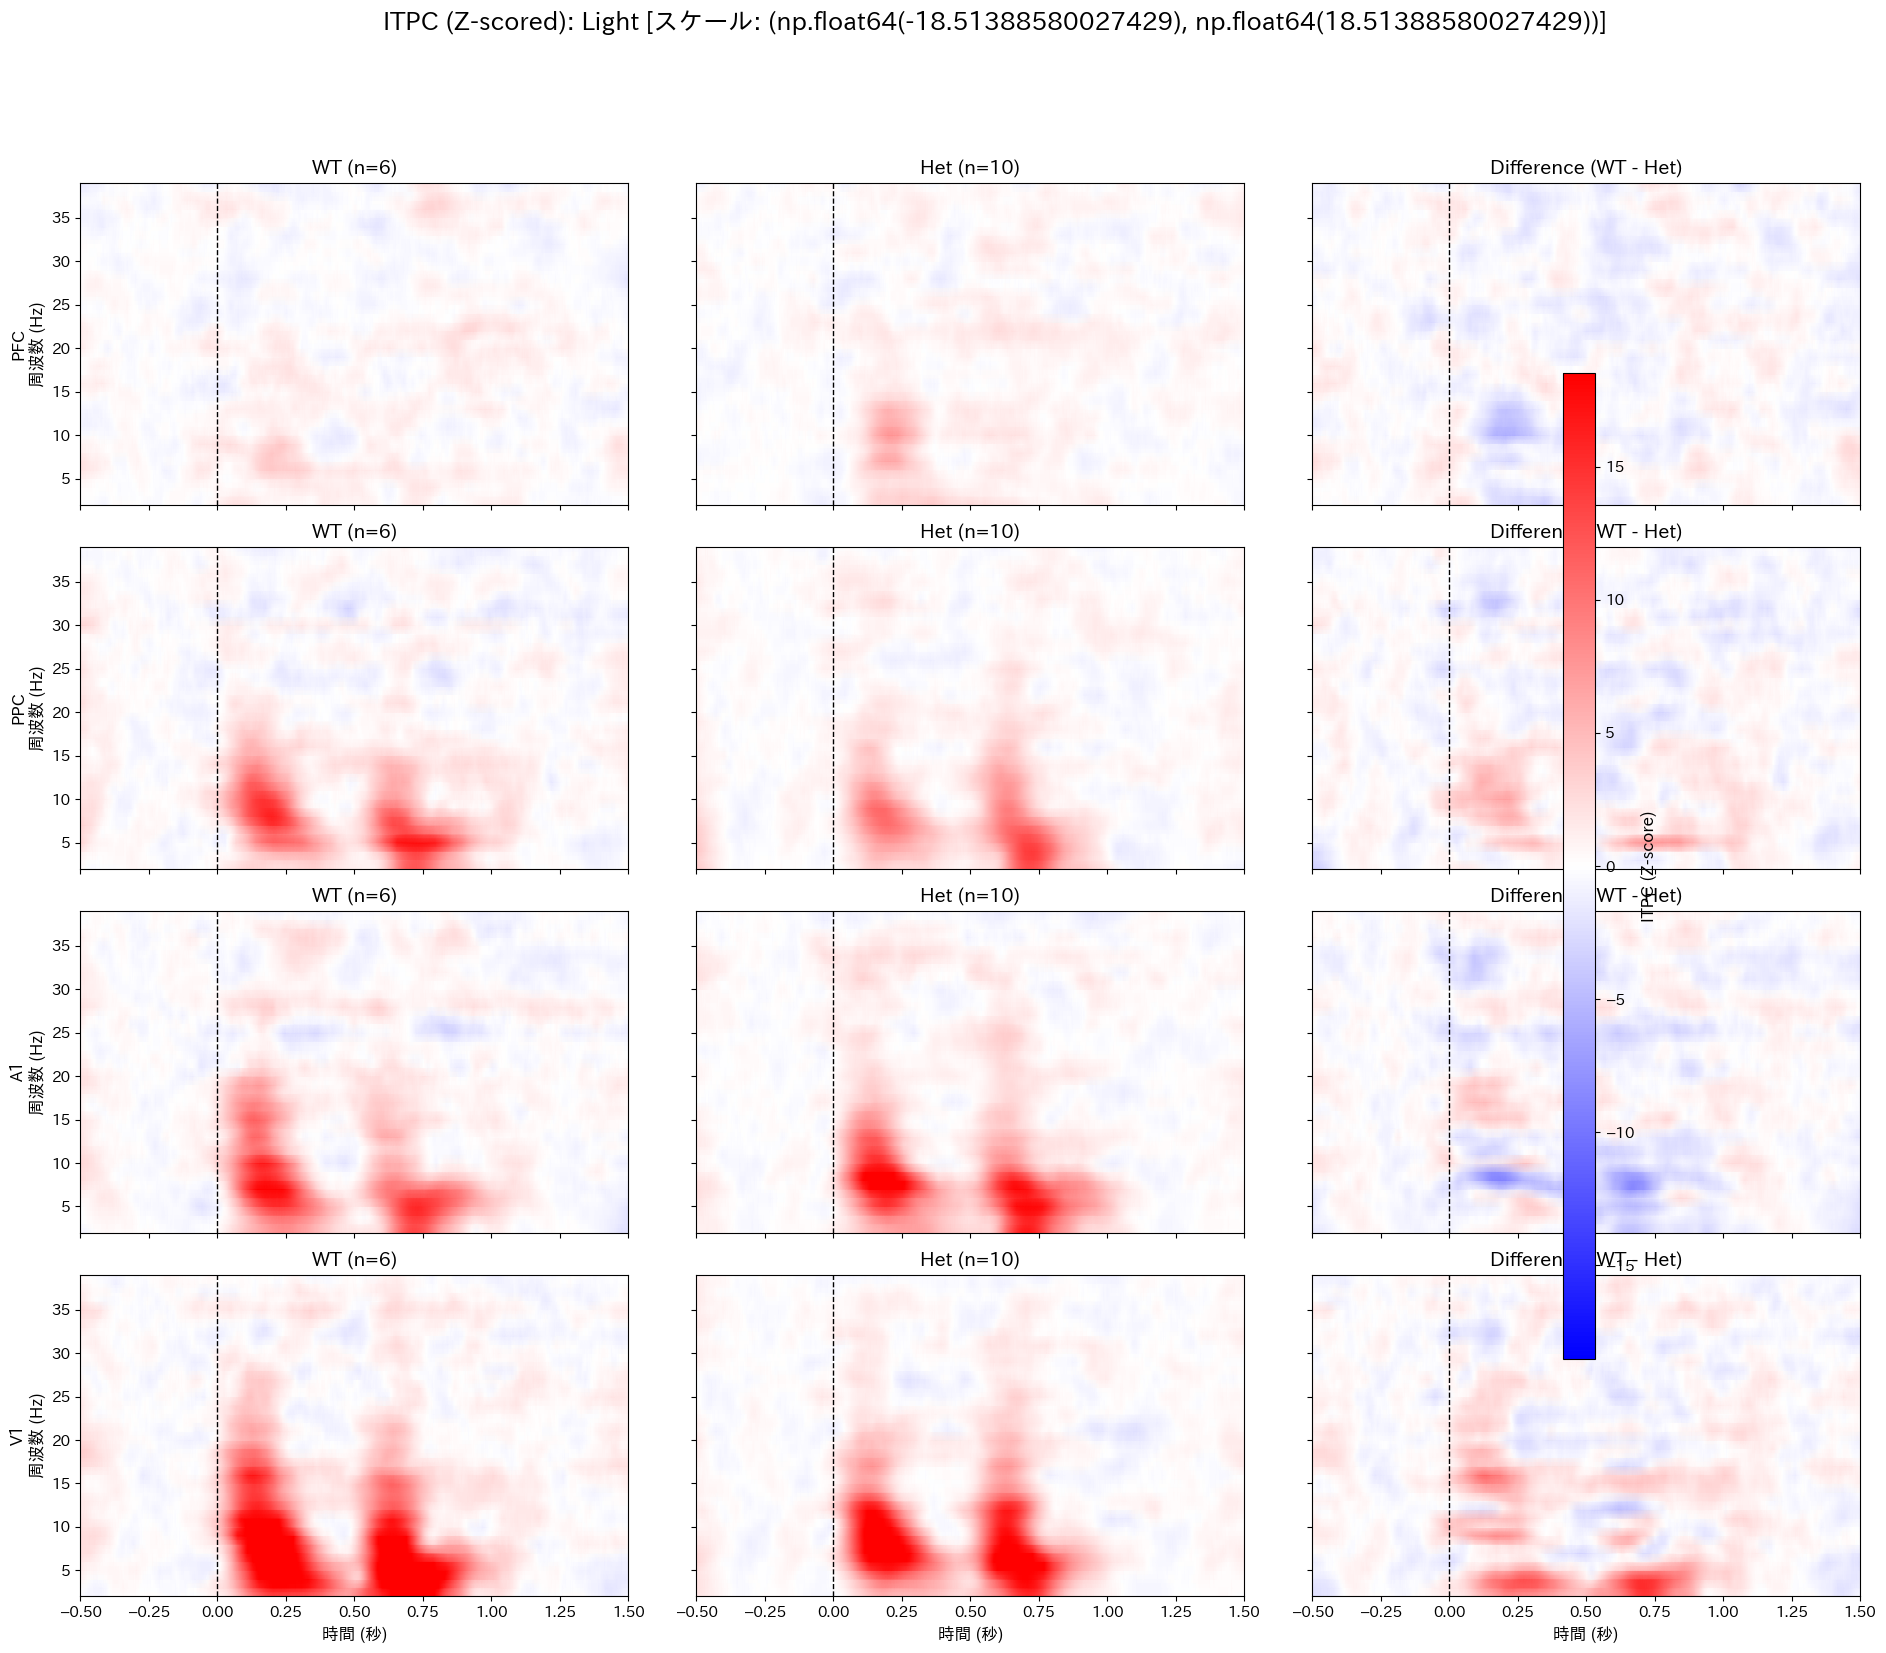

C:\Users\dmasu\AppData\Local\Temp\ipykernel_16148\2980590038.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.94, 0.97]) # topを調整


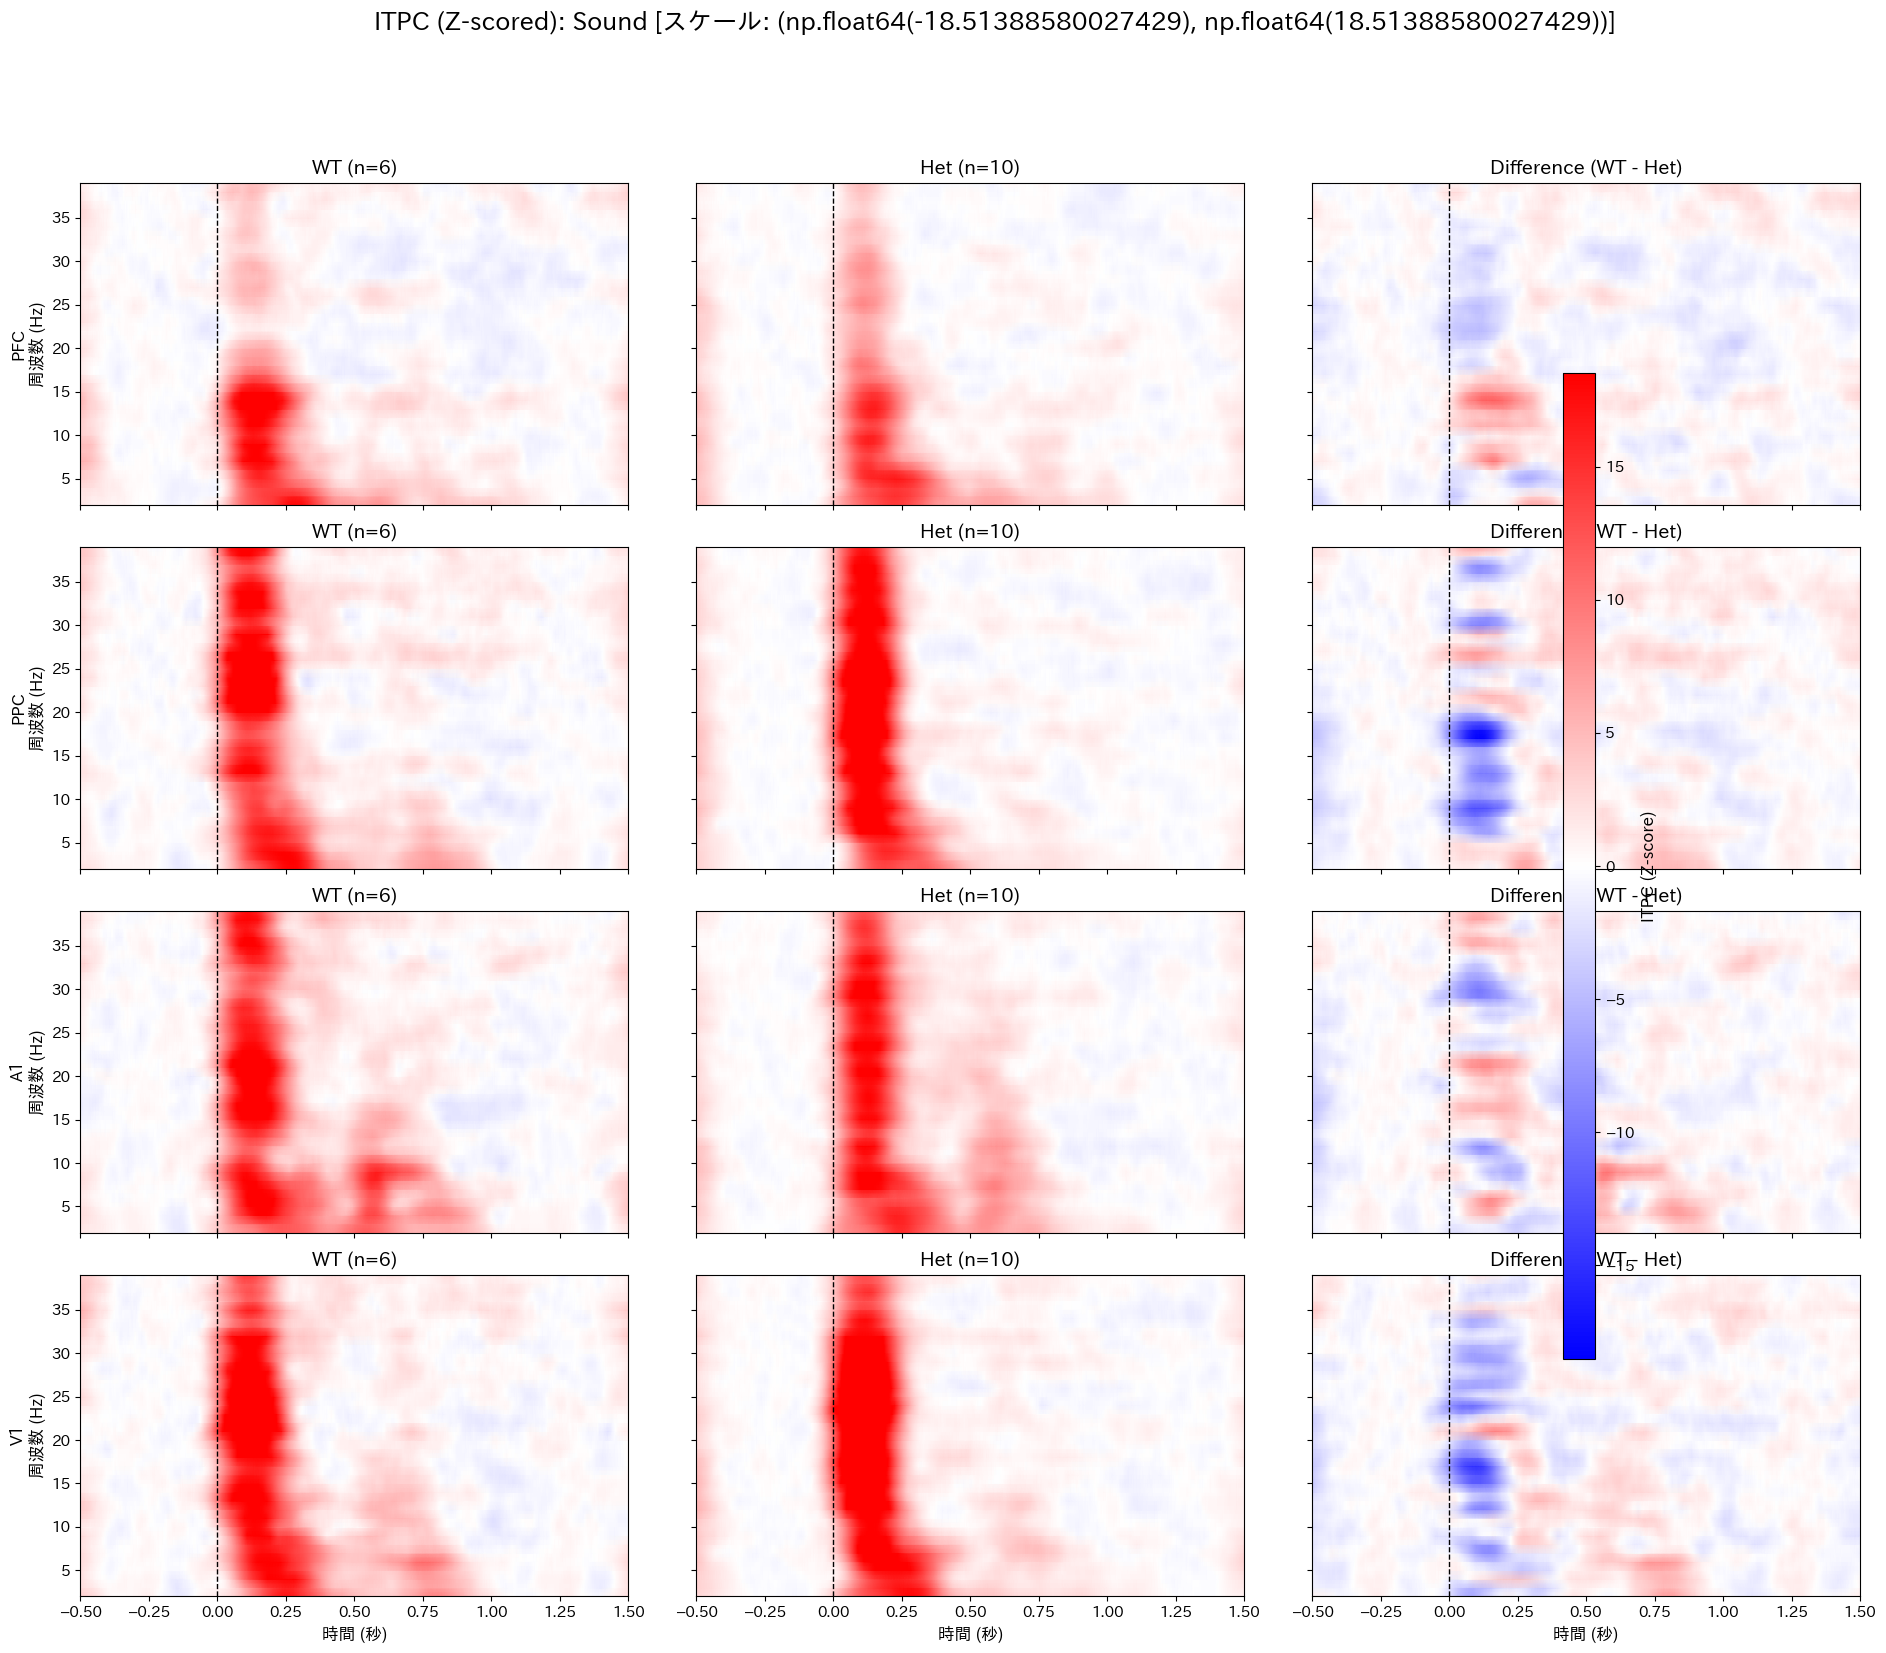

C:\Users\dmasu\AppData\Local\Temp\ipykernel_16148\2980590038.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.94, 0.97]) # topを調整


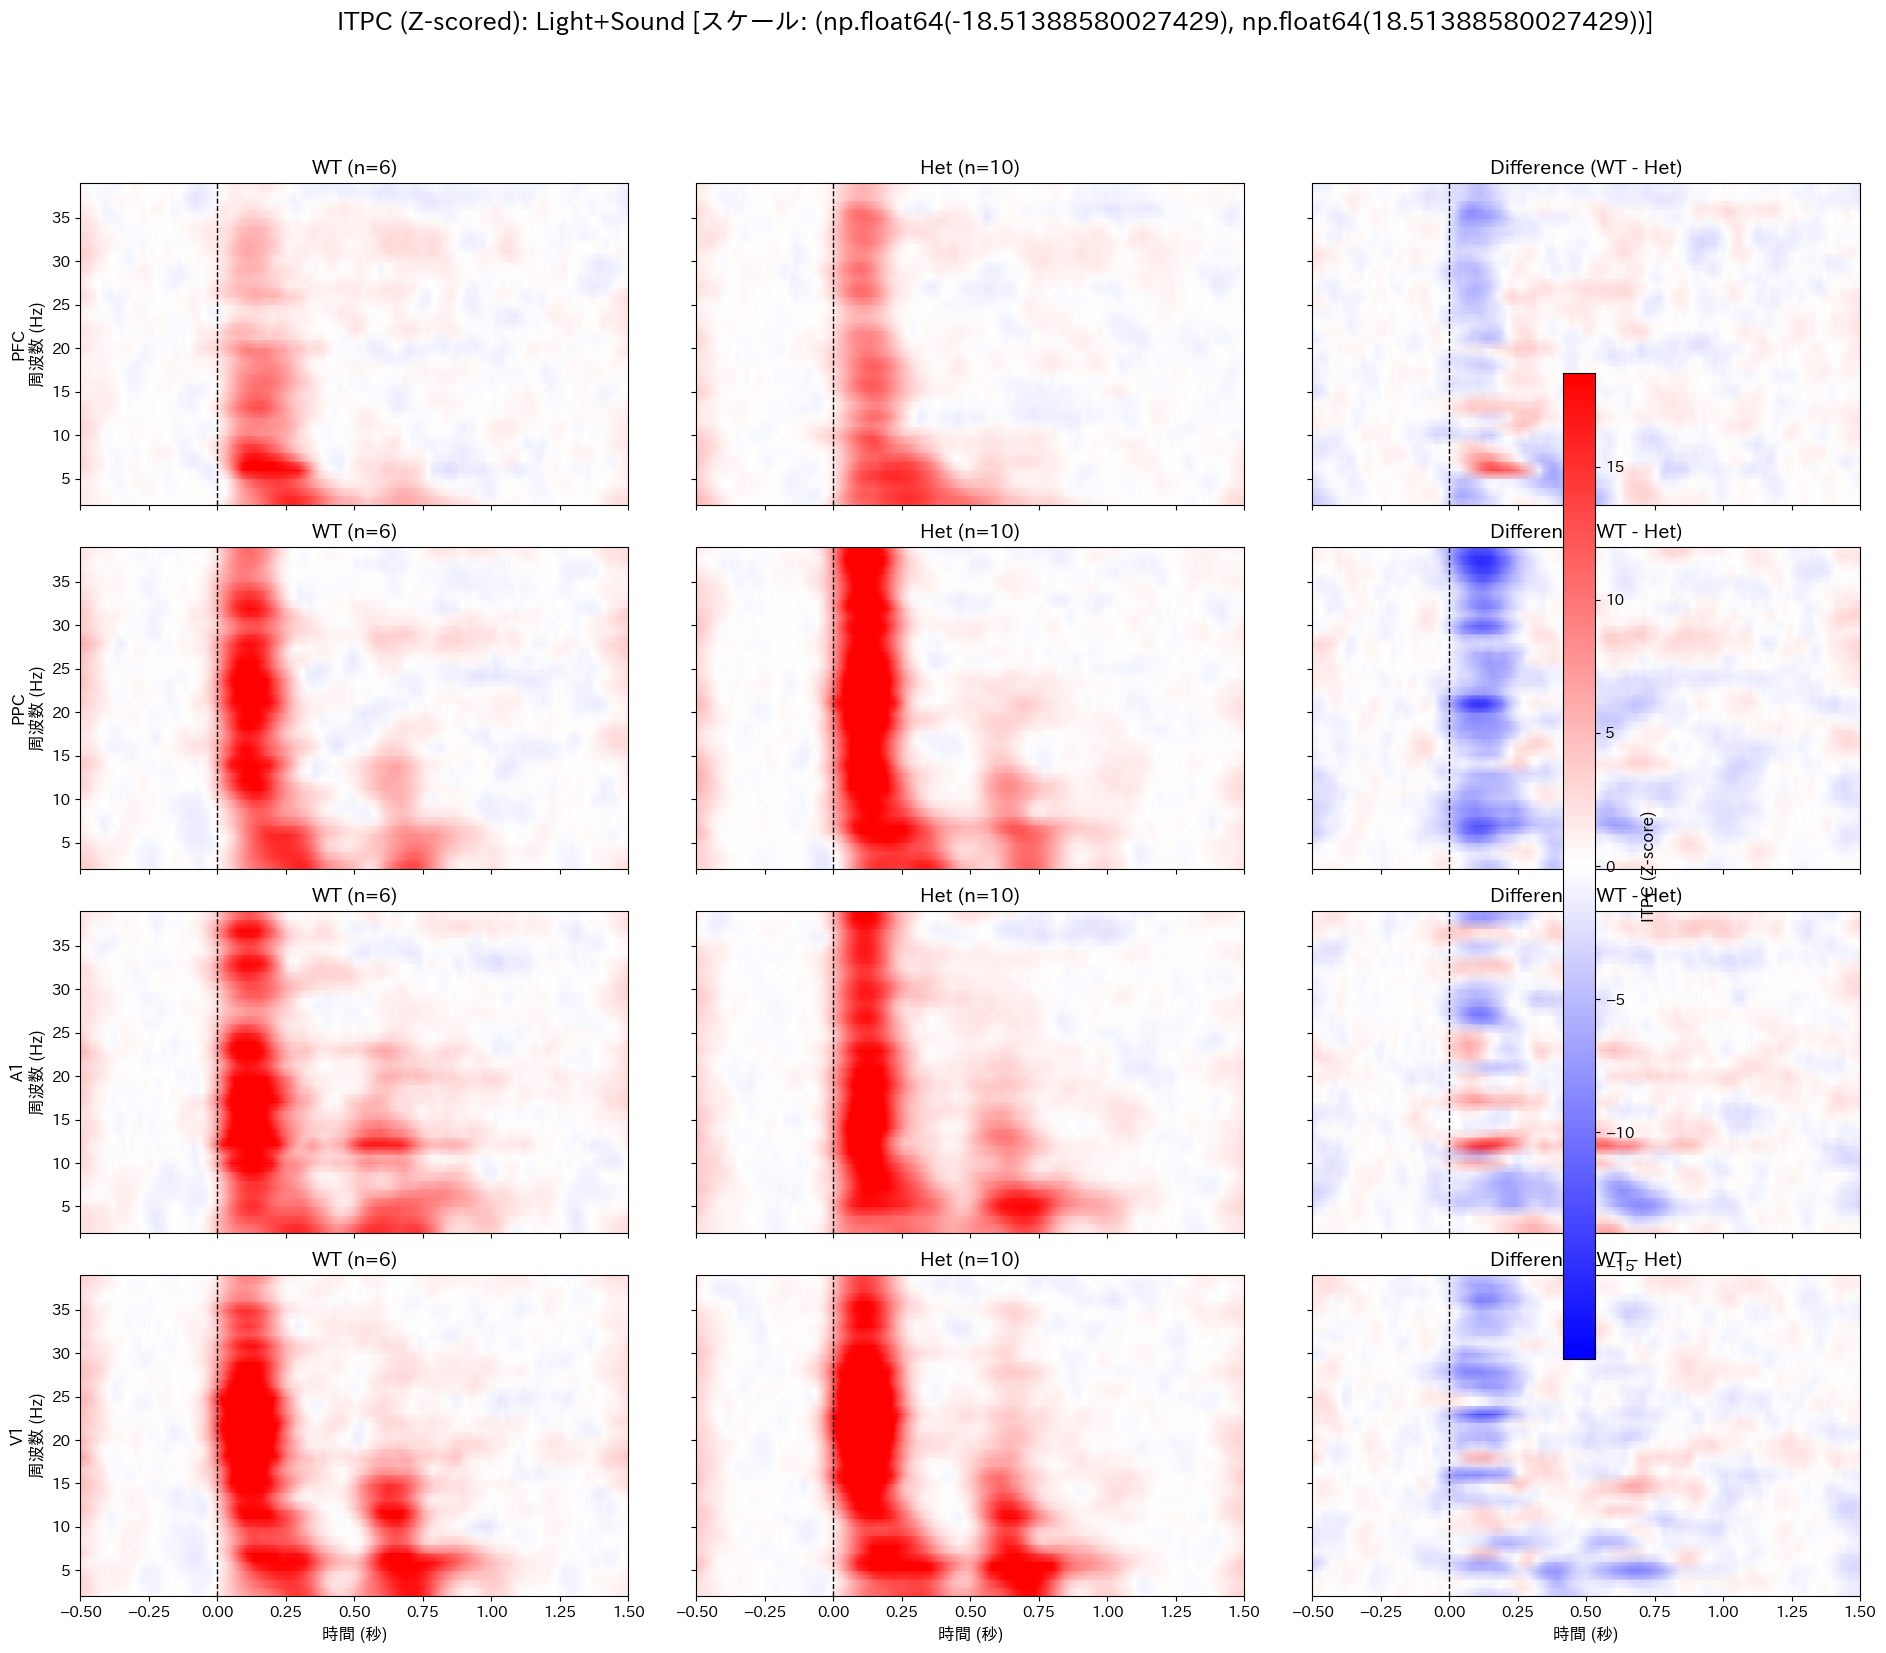

In [14]:
itpc_dataframe = pd.read_parquet(
    PROCESSED_DIR / "summary_itpc_all_subjects.parquet")
plot_grouped_itpc(itpc_dataframe)